#1. Install & Import Libraries and file setup

In [4]:
!pip install rawpy imageio photutils scikit-image

In [5]:
import numpy as np
import rawpy
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from photutils.aperture import CircularAnnulus
import imageio as io
from skimage import filters
import plotly.graph_objects as go

In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
data_dir = "/content/drive/MyDrive/Solar Limb Data"

#2. Utility: Image Display Function

In [21]:
def show_image(img, title="", cmap="gray"):
    plt.figure(figsize=(6,6))

    if img.ndim == 3:  # RGB image
        img_disp = img / 255.0 if img.max() > 1 else img
        plt.imshow(img_disp)
    else:  # grayscale
        plt.imshow(img, cmap=cmap)

    plt.title(title)
    plt.axis("off")
    plt.show()

#3. Load Images

In [22]:
def load_images(file):
    images = [io.imread(file).astype(float)]
    return np.stack(images)

In [23]:
light_dir = os.path.join(data_dir, "Light")
dark_dir = os.path.join(data_dir, "Dark")
flatdark_dir = os.path.join(data_dir, "Flat Dark")


In [36]:
import os

# Redefine file paths using the newly specified directory variables
# Assuming the filenames within these directories are the same as before
light_files = os.path.join(light_dir, "DSC_0531.NEF")
dark_files = os.path.join(dark_dir, "DSC_0428.NEF")
flatdark_files = os.path.join(flatdark_dir, "DSC_0423.NEF")

lights = load_images(light_files)
darks = load_images(dark_files)
flatdarks = load_images(flatdark_files)

/tmp/ipython-input-3895754211.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [io.imread(file).astype(float)]


#4. Master Frames (MEAN COMBINE)

In [37]:
def master_frame(stack):
    return np.mean(stack, axis=0)

In [38]:
master_dark = master_frame(darks)
master_flatdark = master_frame(flatdarks)
master_light = master_frame(lights)

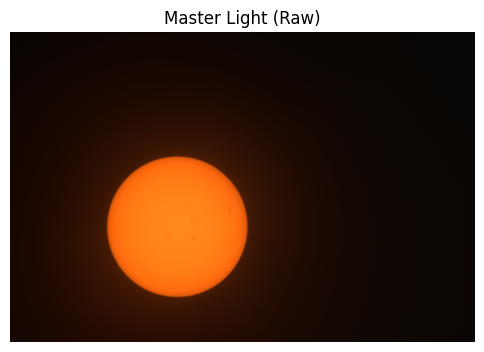

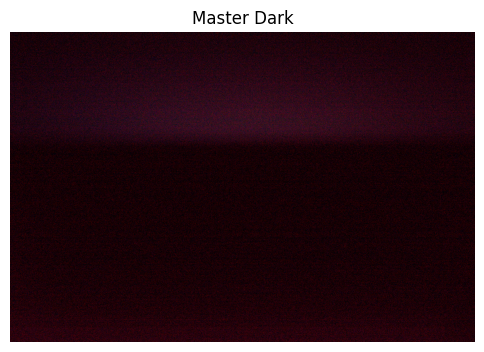

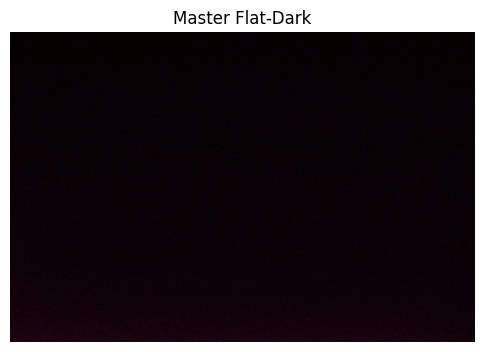

In [39]:
show_image(master_light, "Master Light (Raw)")
show_image(master_dark, "Master Dark")
show_image(master_flatdark, "Master Flat-Dark")

#5. Calibration (NO FLATS)

In [40]:
def calibrate_light(light, dark):
    calibrated = light - dark
    calibrated[calibrated < 0] = 0
    return calibrated

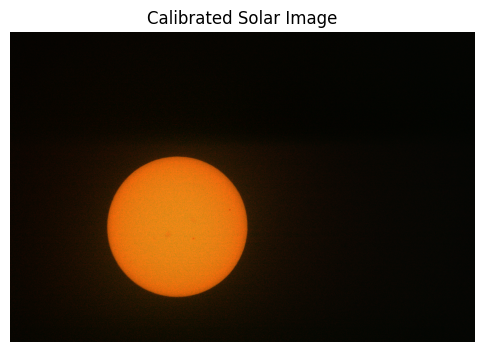

In [41]:
calibrated = calibrate_light(master_light, master_dark)
show_image(calibrated, "Calibrated Solar Image")

#6. RGB Separation

In [32]:
def split_rgb(img):
    return img[:,:,0], img[:,:,1], img[:,:,2]

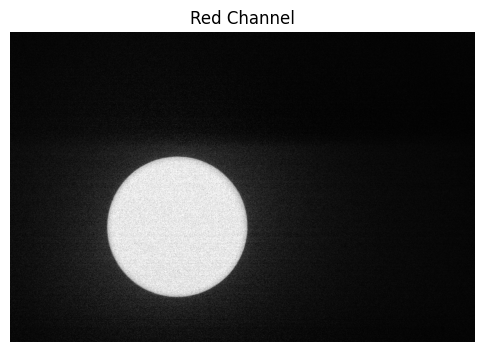

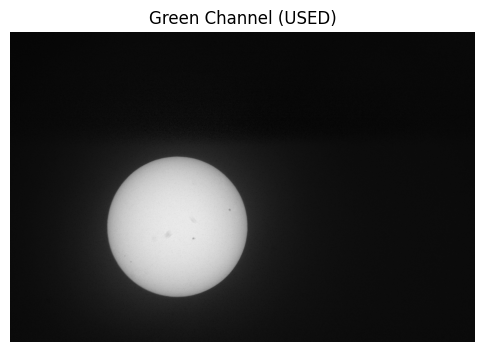

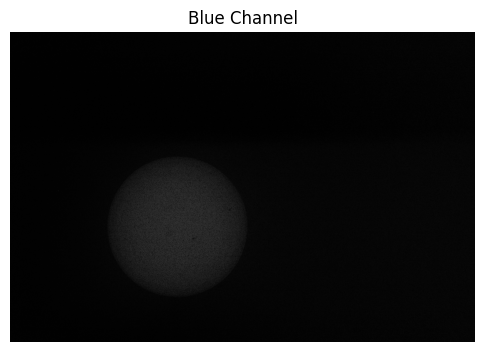

In [33]:
R, G, B = split_rgb(calibrated)

show_image(R, "Red Channel")
show_image(G, "Green Channel (USED)")
show_image(B, "Blue Channel")

#7. Solar Disk Masking

In [42]:
def solar_mask(img, sigma=2):
    smooth = gaussian_filter(img, sigma)
    thresh = filters.threshold_otsu(smooth)
    mask = smooth > thresh
    return mask, smooth

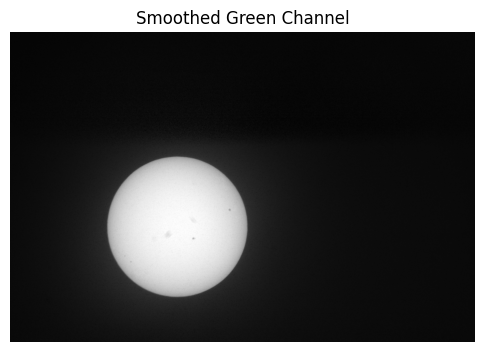

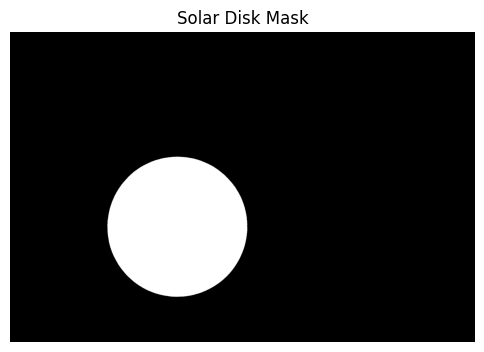

In [43]:
mask, smooth = solar_mask(G)
show_image(smooth, "Smoothed Green Channel")
show_image(mask, "Solar Disk Mask")

#8. Disk Centre & Radius

In [44]:
def disk_geometry(mask):
    y, x = np.indices(mask.shape)
    xc = np.mean(x[mask])
    yc = np.mean(y[mask])
    r = np.sqrt((x-xc)**2 + (y-yc)**2)
    R = np.max(r[mask])
    return xc, yc, R

In [45]:
xc, yc, R = disk_geometry(mask)
print(f"Center = ({xc:.1f}, {yc:.1f}), Radius = {R:.1f}")

Center = (2164.6, 2527.2), Radius = 906.9


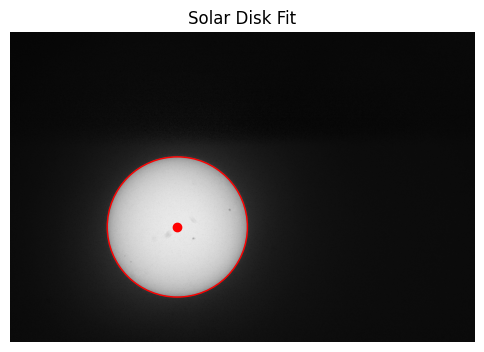

In [46]:
plt.figure(figsize=(6,6))
plt.imshow(G, cmap="gray")
plt.scatter(xc, yc, c='r')
circle = plt.Circle((xc,yc), R, color='r', fill=False)
plt.gca().add_patch(circle)
plt.title("Solar Disk Fit")
plt.axis("off")
plt.show()

#9. Radial Intensity Profile (ANNULI)

In [47]:
def radial_profile(img, xc, yc, R, n_bins=50):
    y, x = np.indices(img.shape)
    r = np.sqrt((x-xc)**2 + (y-yc)**2)
    r_norm = r / R

    bins = np.linspace(0,1,n_bins+1)
    I, mu = [], []

    for i in range(n_bins):
        annulus = (r_norm>=bins[i]) & (r_norm<bins[i+1])
        if np.sum(annulus)>50:
            I.append(np.mean(img[annulus]))
            rmid = 0.5*(bins[i]+bins[i+1])
            mu.append(np.sqrt(1-rmid**2))

    return np.array(mu), np.array(I)

In [48]:
mu, I = radial_profile(G, xc, yc, R)

#10. Normalisation

In [49]:
I_norm = I / np.max(I)

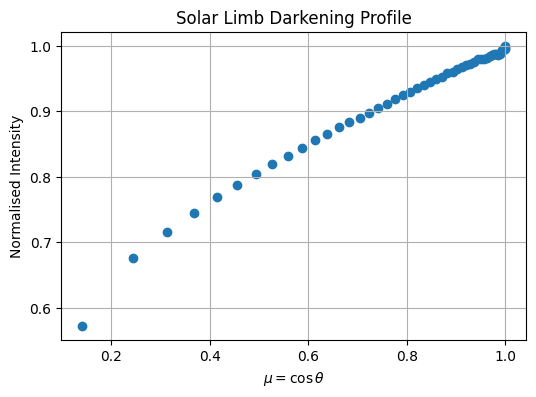

In [50]:
plt.figure(figsize=(6,4))
plt.scatter(mu, I_norm)
plt.xlabel(r"$\mu = \cos\theta$")
plt.ylabel("Normalised Intensity")
plt.title("Solar Limb Darkening Profile")
plt.grid()
plt.show()

In [51]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=mu,
        y=I_norm,
        mode='markers',
        marker=dict(size=7),
        name='Measured'
    )
)

fig.update_layout(
    title="Solar Limb Darkening Profile",
    xaxis_title=r"$\mu = \cos\theta$",
    yaxis_title="Normalised Intensity",
    width=650,
    height=450,
    template="plotly_white"
)

fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

fig.show()

#11. Linear Limb Darkening Fit

In [52]:
def limb_model(mu, u):
    return 1 - u*(1-mu)

In [53]:
popt, pcov = curve_fit(limb_model, mu, I_norm)
u = popt[0]
u_err = np.sqrt(np.diag(pcov))[0]
print(f"Limb Darkening Coefficient u = {u:.3f} ± {u_err:.3f}")

Limb Darkening Coefficient u = 0.409 ± 0.006


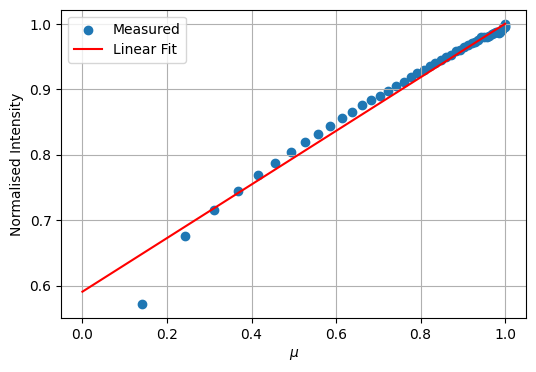

In [54]:
mu_fit = np.linspace(0,1,200)
plt.figure(figsize=(6,4))
plt.scatter(mu, I_norm, label="Measured")
plt.plot(mu_fit, limb_model(mu_fit,u), 'r', label="Linear Fit")
plt.xlabel(r"$\mu$")
plt.ylabel("Normalised Intensity")
plt.legend()
plt.grid()
plt.show()

In [55]:
mu_fit = np.linspace(0, 1, 200)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=mu,
        y=I_norm,
        mode='markers',
        name='Measured'
    )
)

fig.add_trace(
    go.Scatter(
        x=mu_fit,
        y=limb_model(mu_fit, u),
        mode='lines',
        name='Linear Fit'
    )
)

fig.update_layout(
    title="Linear Limb Darkening Fit",
    xaxis_title=r"$\mu = \cos\theta$",
    yaxis_title="Normalised Intensity",
    width=650,
    height=450,
    template="plotly_white"
)

fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

fig.show()
